Hello, before embarking on the journey below I wasn't sure what kind of roadblocks I was going to run into. One of the notable ones was my gpu memory (11gb) limiting the amount of training data I could use. As such, in the immediate cells below ([3:7]) you will find an unnused Imdb dataset.

Quick backstory: after getting my model up an running, I wanted to expand so I found this dataset and spent a significant amount of time cleaning it (in another notebook). After attempting to retrain my model with this combinded dataset (and have it complete training in a resonable amount of time) I decided to just abandon it. May it rest in peace.

Please play this youtube video in tribute:
https://www.youtube.com/watch?v=S-Xrlf3taEo



Movin on, full-disclosure, I used the tutorials below to guide me in writing this notebook. 

The below code is adapted from these tutorials:

(https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=fMSr7C-F_sey)

(https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)

Videos to go along with the tutorials:

(https://www.youtube.com/watch?v=Osj0Z6rwJB4)

(https://www.youtube.com/watch?time_continue=737&v=8N-nM3QW7O0&feature=emb_logo)


# Setup:

In [1]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers,matplotlib,json

CPython 3.7.7
IPython 7.13.0

numpy 1.18.5
pandas 1.0.4
torch 1.5.0
transformers 2.11.0
matplotlib 3.2.1
json 2.0.9


In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import os as os
import sys as sys
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rc
from pylab import rcParams
from torch import nn, optim
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import json
import pandas as pd
import urllib.parse
import urllib.request
from time import sleep
from pandas import json_normalize

#set graph config
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

#set seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

#check gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
#load training datasets:

#1)
# imdb from http://ai.stanford.edu/~amaas/data/sentiment/
#"We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing."
#this file was larger than 100mb (github's file size limit)
df_imdb = pd.read_csv('imdb.csv')
# 0 = negative
# 1 = neutral 
# 2 = postitive
  
#2)
#google play app reviews ~16k
df_google = pd.read_csv("reviews.csv")

In [4]:
#inspect df_imdb
df_imdb.head(0)

Empty DataFrame
Columns: [content, sentiment]
Index: []

In [5]:
df_imdb.shape

(100000, 2)

In [6]:
#check for misisng values
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   content    100000 non-null  object
 1   sentiment  100000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


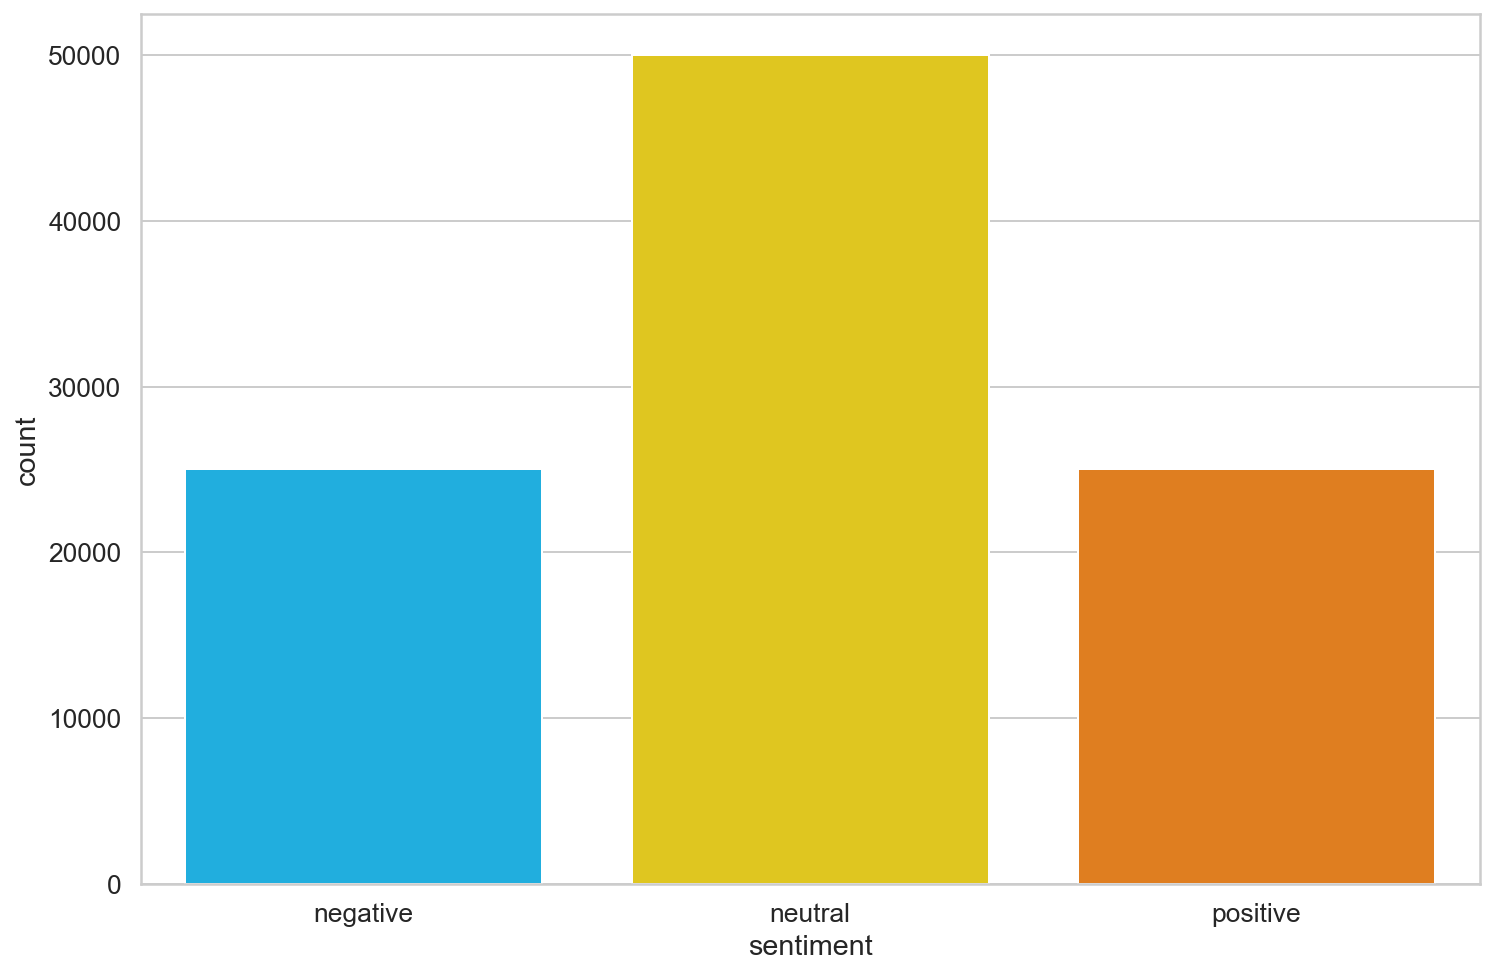

In [7]:
# let's look a the scores

# 0 = negative
# 1 = neutral 
# 2 = postitive


#review changes
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df_imdb.sentiment)
plt.xlabel('review sentiment')
sns.countplot(df_imdb.sentiment)
ax.set_xticklabels(class_names);

Setup google reivews.

In [8]:
#inspect google review
df_google.head(0)

Empty DataFrame
Columns: [userName, userImage, content, score, thumbsUpCount, reviewCreatedVersion, at, replyContent, repliedAt, sortOrder, appId]
Index: []

In [9]:
df_google.shape

(15746, 11)

In [10]:
#We have about 16k examples, Let's check for missing values:

In [11]:
df_google.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


In [12]:
#No missing values, noice. 

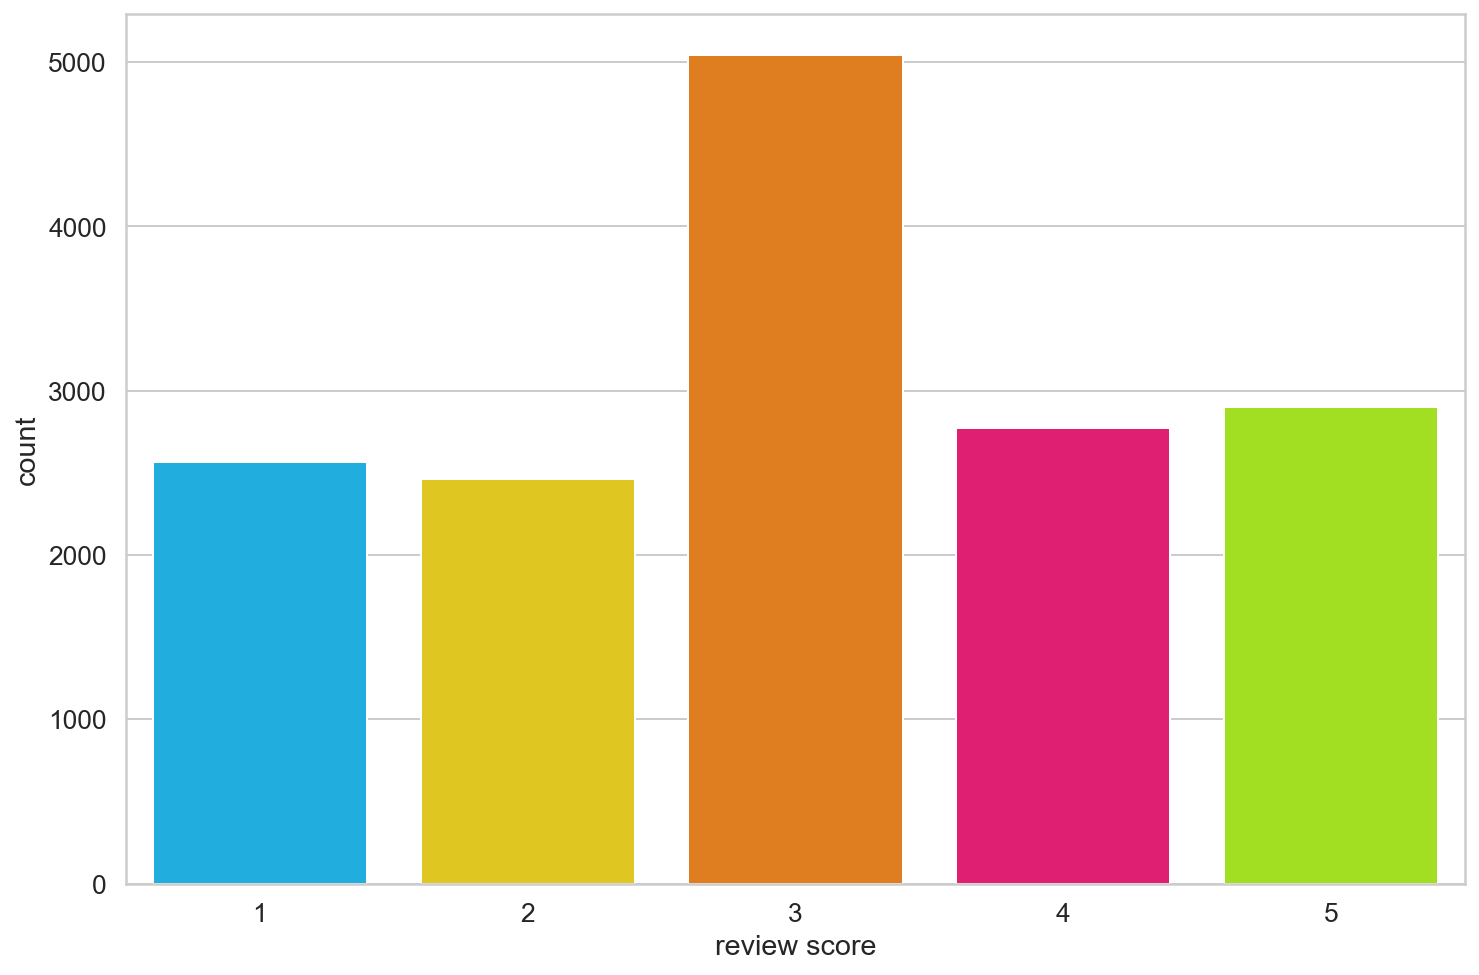

In [13]:
#Let's look at our revies
sns.countplot(df_google.score)
plt.xlabel('review score');

In [14]:
#The imbalce is ok, because we're dividing between negative(1,2) neutral(3) and positive (4,5)
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

#apply above function to dataset
df_google['sentiment'] = df_google.score.apply(to_sentiment)

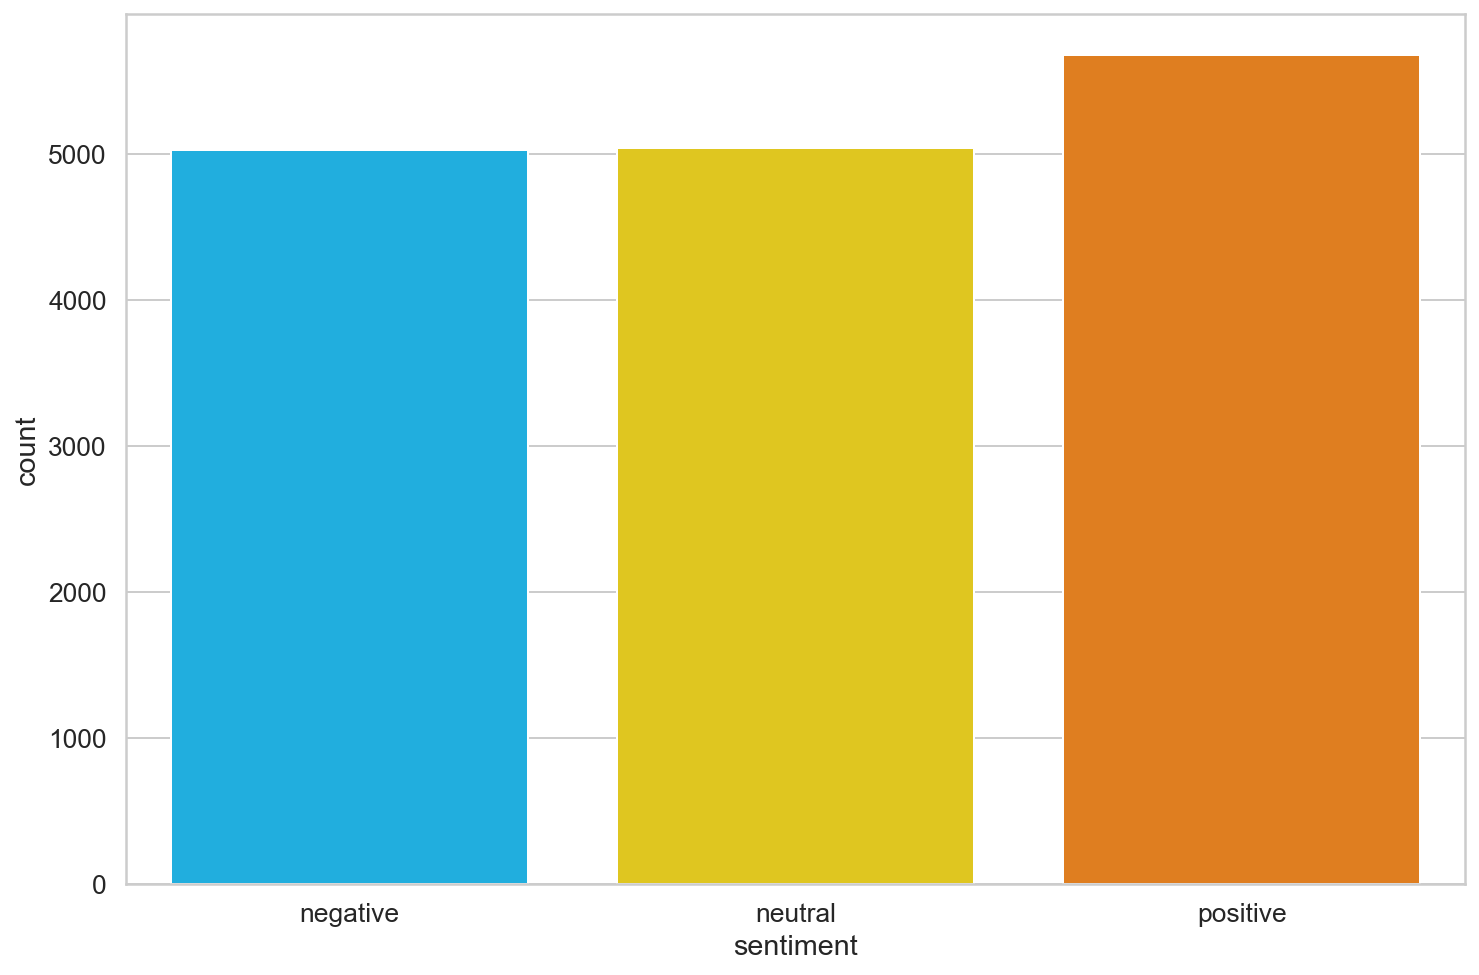

In [15]:
#review changes
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df_google.sentiment)
plt.xlabel('review sentiment')
sns.countplot(df_google.sentiment)
ax.set_xticklabels(class_names);

In [16]:
# the balance is (mostly) restored. 
df_google.head()

userName                                          userImage  \
0     Andrew Thomas  https://lh3.googleusercontent.com/a-/AOh14GiHd...   
1      Craig Haines  https://lh3.googleusercontent.com/-hoe0kwSJgPQ...   
2     steven adkins  https://lh3.googleusercontent.com/a-/AOh14GiXw...   
3  Lars Panzerbjørn  https://lh3.googleusercontent.com/a-/AOh14Gg-h...   
4     Scott Prewitt  https://lh3.googleusercontent.com/-K-X1-YsVd6U...   

                                             content  score  thumbsUpCount  \
0  Update: After getting a response from the deve...      1             21   
1  Used it for a fair amount of time without any ...      1             11   
2  Your app sucks now!!!!! Used to be good but no...      1             17   
3  It seems OK, but very basic. Recurring tasks n...      1            192   
4  Absolutely worthless. This app runs a prohibit...      1             42   

  reviewCreatedVersion                   at  \
0             4.17.0.3  2020-04-05 22:25:57   
1             4.17.0.3  2020-04-04 13:40:01   
2             4.17.0.3  2020-04-01 16:18:13   
3             4.17.0.2  2020-03-12 08:17:34   
4             4.17.0.2  2020-03-14 17:41:01   

                                        replyContent            repliedAt  \
0  According to our TOS, and the term you have ag...  2020-04-05 15:10:24   
1  It sounds like you logged in with a different ...  2020-04-05 15:11:35   
2  This sounds odd! We are not aware of any issue...  2020-04-02 16:05:56   
3  We do offer this option as part of the Advance...  2020-03-15 06:20:13   
4  We're sorry you feel this way! 90% of the app ...  2020-03-15 23:45:51   

       sortOrder      appId  sentiment  
0  most_relevant  com.anydo          0  
1  most_relevant  com.anydo          0  
2  most_relevant  com.anydo          0  
3  most_relevant  com.anydo          0  
4  most_relevant  com.anydo          0

In [17]:
# merge google and imdb datasets

#subset google for relavent info
df_google_subset = df_google[['content', 'sentiment']]

frames = [df_google_subset] #I omitted df_imdb, due to limited gpu memory
df = pd.concat(frames)
df

content  sentiment
0      Update: After getting a response from the deve...          0
1      Used it for a fair amount of time without any ...          0
2      Your app sucks now!!!!! Used to be good but no...          0
3      It seems OK, but very basic. Recurring tasks n...          0
4      Absolutely worthless. This app runs a prohibit...          0
...                                                  ...        ...
15741  I believe that this is by far the best app wit...          2
15742                       It sometimes crashes a lot!!          2
15743                         Works well for what I need          2
15744                                           Love it.          2
15745  Really amazing and helped me sooo much just i ...          2

[15746 rows x 2 columns]

# Token Processing

1) Add special tokens to separate sentences and do classification

2) Pass sequences of constant length (introduce padding)

3) Create array of 0s (pad token) and 1s (real token) called 'attention mask'

In [18]:
#there are two model types to choose from, case and uncased. 
#We're using 'cased', as "BAD" might convey more sentiment than "bad".

#identify model
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [19]:
#load pre-trained BertTokenizer
#https://huggingface.co/transformers/model_doc/bert.html#berttokenizer

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

#if you get an error, execute 'conda install -c conda-forge ipywidgets' in your env:
#https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [20]:
#sample text 
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

#sample tokenizer
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [21]:
#alright, that's cool, now let's look at the different kinds of tokens..

In [22]:
#Special Tokens:

#[SEP] - marker for ending of a sentence
print(tokenizer.sep_token, tokenizer.sep_token_id)

#[CLS] - marker for start of a sentence, flags sentence for bert-classification
print(tokenizer.cls_token, tokenizer.cls_token_id)

#[PAD] - marker for everything in between
print(tokenizer.pad_token, tokenizer.pad_token_id)

#[UNK] - marker for unknown items
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [23]:
#now let's tokenize our sample_txt with an encoding method, encore_plut()
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

#inspect keys
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [24]:
#token ids are now stored in a Tensor, padded to a length of 32
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]


32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [25]:
#attention mask is stored at the same length
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

# Now let's process our training dataset.

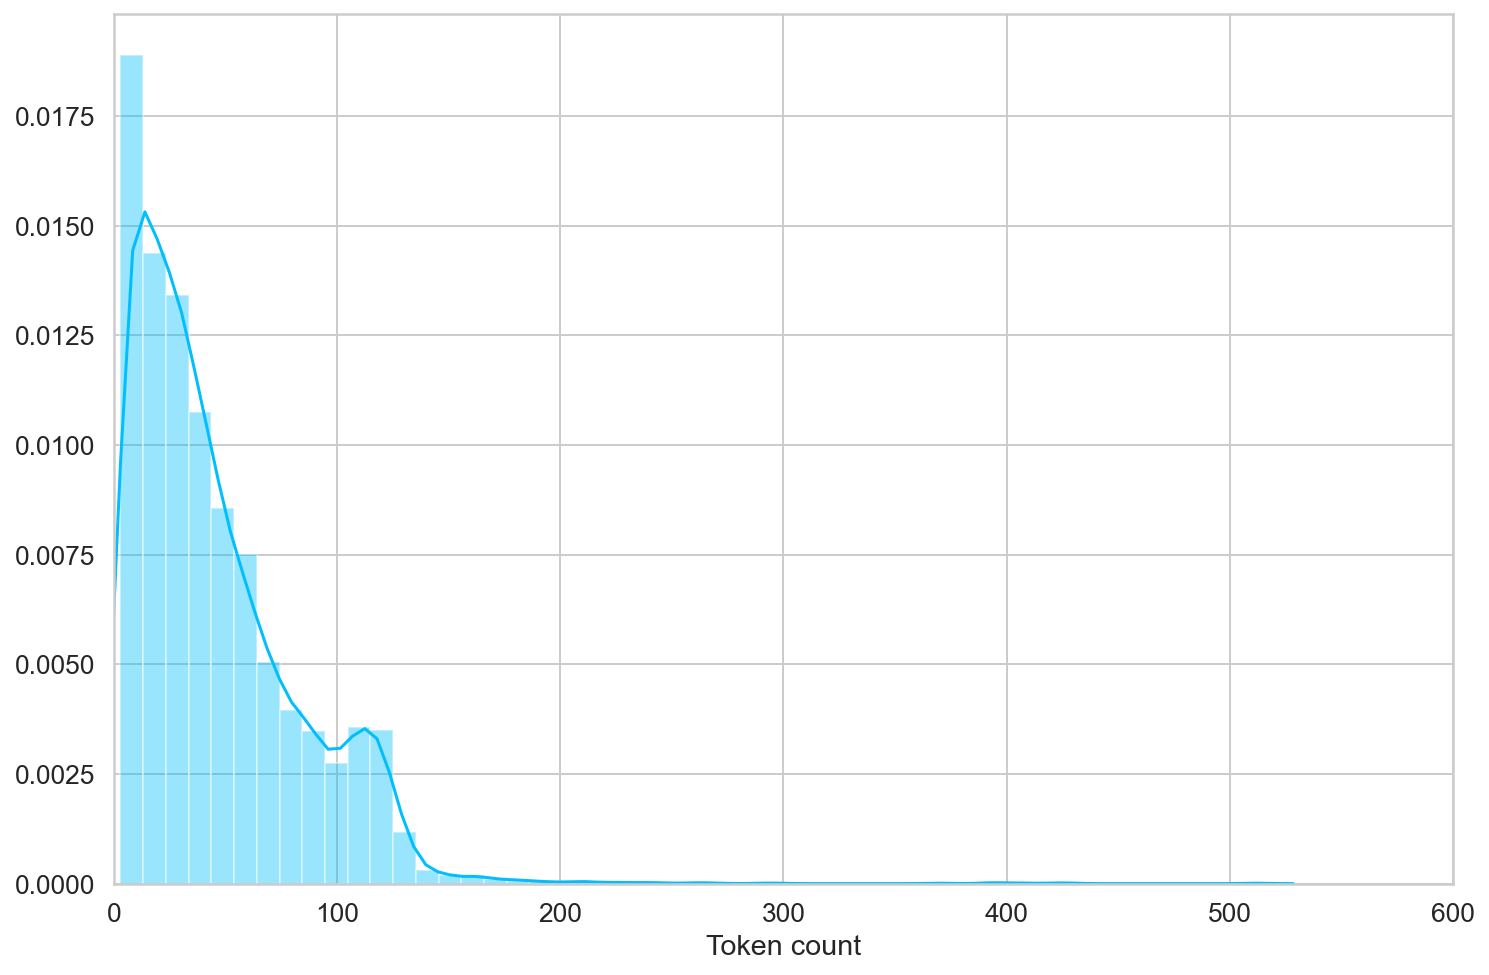

In [26]:
#BERT works with fixed-length sequences. Let's inspect the length of each review from our training dataset and tokenize it

token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512) #max len of this model is 512, sadly
  token_lens.append(len(tokens))
    
#let's plot the distribution to get a sense of what we're working with
sns.distplot(token_lens)
plt.xlim([0, 600]);
plt.xlabel('Token count');

In [27]:
#as a result of trial and error, due to gpu memeory limitations, we need to set a max len of our tensors to 400.
MAX_LEN = 150

In [28]:
#let's format our dataset to PyTorch dataset.

class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [29]:
#test-train-split training data
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [30]:
#inspect
df_train.shape, df_val.shape, df_test.shape

((14171, 2), (787, 2), (788, 2))

In [31]:
#data loader, that's required in the tutorial. I see that it's converting things to numpy arrays, 
#but aside from that, that's all I understand (sadly)

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0 #when running pytorch in windows, not linux, you need to set this to zero or it crashes.  
  )               #https://github.com/pytorch/pytorch/issues/2341

In [32]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [33]:
#let's look at an example batch from out trining data loader:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [34]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


# Sentiment Classification with BERT and Hugging Face

In [35]:
# load model:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [36]:
#test model on our 'sample_text'
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

#output
last_hidden_state.shape

torch.Size([1, 32, 768])

In [37]:
#the 768 is the number of hidden units in the feedfoward-network
bert_model.config.hidden_size

768

In [38]:
#we use this knowledge to make a classifier that uses the BERT mdoel:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [39]:
#let's make an instace if the the above class and move it to our GPU
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [40]:
#let's move the example batch of our training data to the GPU:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 150])
torch.Size([16, 150])


In [41]:
#get predicted probabilities from out trained model, then apploy softmax funciton to the outputs
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4167, 0.1629, 0.4204],
        [0.5268, 0.1343, 0.3389],
        [0.2718, 0.1268, 0.6015],
        [0.5324, 0.1180, 0.3496],
        [0.6053, 0.1680, 0.2267],
        [0.3334, 0.1828, 0.4838],
        [0.4221, 0.1138, 0.4641],
        [0.3167, 0.2619, 0.4215],
        [0.3325, 0.1465, 0.5211],
        [0.2637, 0.1996, 0.5367],
        [0.4092, 0.1467, 0.4441],
        [0.3765, 0.2127, 0.4107],
        [0.5731, 0.0732, 0.3537],
        [0.4752, 0.1724, 0.3525],
        [0.3837, 0.1831, 0.4332],
        [0.3463, 0.2110, 0.4427]], device='cuda:0', grad_fn=<SoftmaxBackward>)

# Training

In [42]:
EPOCHS = 4 #I went with 4 after testing several times.

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [43]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [44]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [45]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/4
----------
Train loss 0.721916234621076 accuracy 0.6706654435113966
Val   loss 0.5842906340956688 accuracy 0.7649301143583228

Epoch 2/4
----------
Train loss 0.3985824018893406 accuracy 0.8513160680262508
Val   loss 0.5016115181148052 accuracy 0.8386277001270649

Epoch 3/4
----------
Train loss 0.2205375970360186 accuracy 0.9283748500458684
Val   loss 0.5816717040538788 accuracy 0.8602287166454893

Epoch 4/4
----------
Train loss 0.14579379186034203 accuracy 0.955825276974102
Val   loss 0.6304435113072395 accuracy 0.8564167725540026

Wall time: 16min 37s


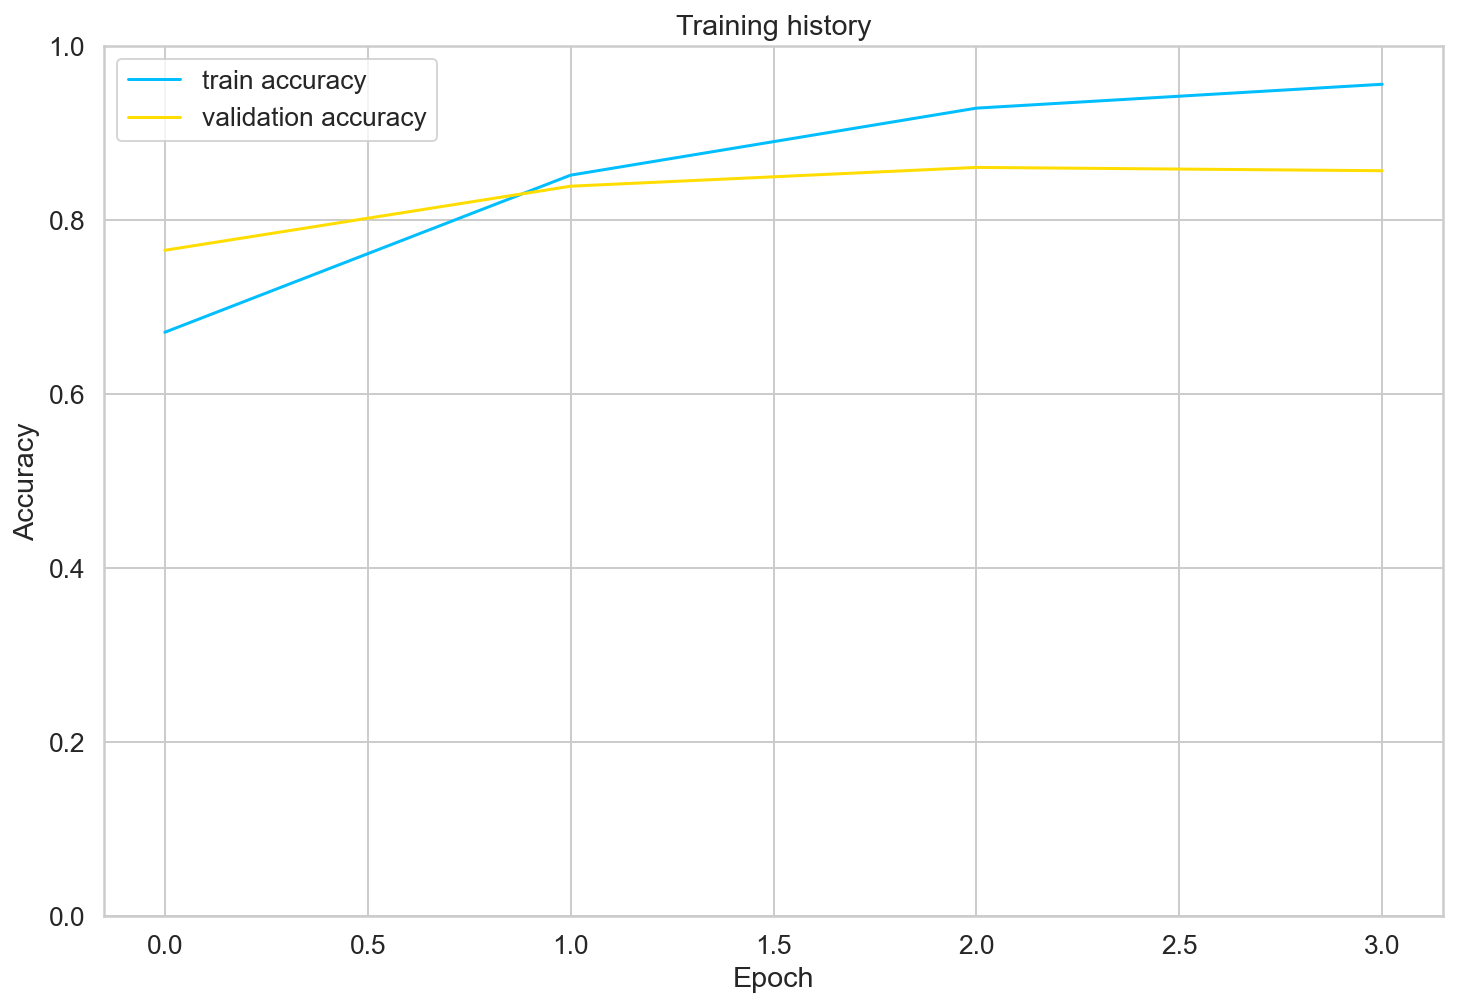

In [46]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# Predicting Raw Text (New York Times articles)

In [47]:
# open text file from nyt api extraction preformed in r 
urls = open("urls.txt", "r")

In [48]:
# preform final cleaning of urls:


# select rows containing urls
temp_lst = []
for item in urls:
    if item[0] == 'R':
        temp_lst.append(item)

# chop off extra string in front of url
temp_lst_2 = []
for item in temp_lst:
    item = item.replace('Response [', '')
    temp_lst_2.append(item)

# chop off extra string at end of url
urls = []
for item in temp_lst_2:
    item = item.replace(']\n', '')
    urls.append(item)

#remove unnsed lists from memory
temp_lst = None
temp_lst_2 = None

In [49]:
#open urls, extract the title of the article, and store it for sentiment analysis
#took several hours (I think 4?) because of nyt api restrictions (sleep(6.0))

#empty title list
title_lst = []

for item in urls:
    #open url
    url = urllib.request.urlopen(item)
    
    #read it
    title_temp = json.loads(url.read().decode())
    
    #subset it, to article title level
    title_temp = title_temp['response']
    title_temp = title_temp['docs']
    
    #final subset and append to title_lst
    for i in title_temp:
        title_lst.append(i['abstract'])
        
    #wait 6 seconds because nyt api restrictions
    sleep(6.0)

In [50]:
# pass each nyt title through sentiment model
review_text_lst = []
prediction_lst = []

for item in title_lst:
    encoded_review = tokenizer.encode_plus(item, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt',)
    
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    
    review_text_lst.append(item)
    prediction_lst.append(class_names[prediction])

In [51]:
#count up your glorious sentiment results
pos_count = 0
neg_count = 0
neu_count = 0

for item in prediction_lst:
    if item == 'positive':
        pos_count += 1
    elif item == 'neutral':
        neu_count += 1
    else:
        neg_count += 1

In [52]:
print('Positive articles: ', pos_count)
print('Negative articles: ', neg_count)
print('Neutral articles: ', neu_count)

Positive articles:  1928
Negative articles:  2855
Neutral articles:  1849


Not to my suprise, I found an abundance of article titles with negative sentiments. Interestingly there were, roughly, the same amount of positive titles as there were neutral. Worth. 